# Surface temperature
Data downloaded from [https://data.giss.nasa.gov/](https://data.giss.nasa.gov/)   
(file `gistemp1200_GHCNv4_ERSSTv5.nc`).

In [1]:
import sys
sys.path.insert(0, '..')
import os
import glob
import numpy as np
from filament import filament
import datetime
import cmocean
import logging
import netCDF4
import calendar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PathCollection
from matplotlib.path import Path
from importlib import reload
reload(filament)
plt.rcParams.update({'font.size': 18})

In [2]:
from matplotlib.font_manager import FontProperties
fontfile = "/home/ctroupin/.fonts/D-DIN.ttf"
myfont = FontProperties(fname=fontfile)

## Logger

In [3]:
logger = logging.getLogger("SSTanom")
logger.setLevel(logging.INFO)
logging.info("Starting")

## Files and directories

In [7]:
figdir = "../figures/"
datafile = "/data/GISTEMP/gistemp1200_GHCNv4_ERSSTv5.nc"
if not os.path.exists(figdir):
    os.makedirs(figdir)
bgcolor = "white"
fgcolor = "black"

## Data reading

In [8]:
def load_data_anom(datafile):
    with netCDF4.Dataset(datafile) as nc:
        lat = nc.variables["lat"][:]
        lon = nc.variables["lon"][:]
        time = nc.variables["time"][:]
        timeunits = nc.variables["time"].units
        dates = netCDF4.num2date(time, timeunits)
        Tanom = nc.variables["tempanomaly"][:]
        
    return lon, lat, dates, Tanom

In [9]:
lon, lat, dates, Tanom = load_data_anom(datafile)

## Plot preparation
### Projection

In [10]:
#m = Basemap(projection='ortho', lon_0=-52., lat_0=10, resolution='i')
m = Basemap(projection='robin',resolution='i',lat_0=0,lon_0=0)
llon, llat = np.meshgrid(lon, lat)
lonp, latp = m(llon, llat)
lonp[lonp==lonp.max()] = np.nan
latp[latp==latp.max()] = np.nan

### Coastline

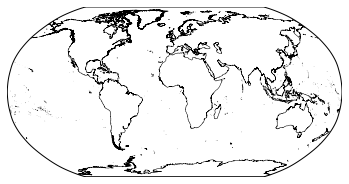

In [11]:
shp_info = m.readshapefile('/data/ShapeFiles/ne_10m_land/ne_10m_land', 'scalerank', drawbounds=True)
paths = []
for line in shp_info[4]._paths:
    paths.append(Path(line.vertices, codes=line.codes))
coll = PathCollection(paths, linewidths=0, facecolors='grey', zorder=2)

### Plotting function

In [12]:
def make_monthly_subplot(m, lon, lat, temperature_anom, NN=1, fgcolor="k"):
    
    #if figtitle is not None:
    #    plt.title(figtitle, fontsize=18, color=fgcolor)
        
    pcm = m.pcolor(lon[::NN,::NN], lat[::NN,::NN], temperature_anom[::NN,::NN],
                       cmap=plt.cm.RdBu_r, vmin=-5, vmax=5, zorder=2)

    m.drawmapboundary(color='white', 
                  linewidth=0.0, 
                  fill_color='white')
        
    cmap = mpl.cm.RdBu_r

    normanom = mpl.colors.Normalize(vmin=-5, vmax=5)
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
    cb = plt.colorbar(pcm, cax=cbar_ax, shrink=.7, cmap=cmap, norm=normanom,
                 orientation='horizontal', extend="both")
    
    cb.set_label("$^{\circ}$C", fontsize=18, color=fgcolor, fontweight="bold")
    cb.ax.tick_params(axis='x', colors=fgcolor)
    
    return pcm, cb

## Plot
### 2020 only

In [13]:
vmin = -5.
vmax = 5.
normanom = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

INFO:SSTanom:Saving figure


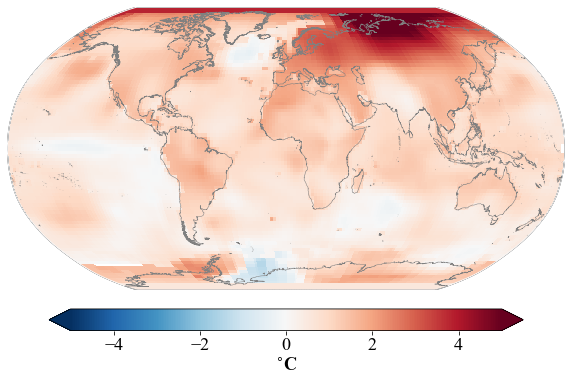

In [14]:
Tanom2020 = np.nanmean(Tanom[-12:,:,:], axis=0)
fig = plt.figure(figsize=(10, 7))

ax = plt.gca()
ax.cla()

shp_info = m.readshapefile('/data/ShapeFiles/ne_10m_land/ne_10m_land', 'scalerank', drawbounds=True)
paths = []
for line in shp_info[4]._paths:
    paths.append(Path(line.vertices, codes=line.codes))

coll = PathCollection(paths, linewidths=0.5, facecolors='None', edgecolor=".5", zorder=4)
ax = plt.gca()
ax.cla()

figtitle = "Surface temperature anomalies - 2020"
#plt.title(figtitle)

pcm = m.pcolor(lonp, latp, Tanom2020,
                   cmap=plt.cm.RdBu_r, vmin=vmin, vmax=vmax, zorder=2)

m.drawmapboundary(
color='w',
linewidth=1.0,
fill_color='none', zorder=2)

cb = plt.colorbar(pcm, shrink=.85, norm=normanom,
             orientation='horizontal', extend="both", pad=0.05)

cb.set_label("$^{\circ}$C", fontsize=18, color=fgcolor, fontweight="bold")
cb.ax.tick_params(axis='x', colors=fgcolor)


ax = plt.gca()
ax.add_collection(coll)

logger.info("Saving figure")

plt.savefig(os.path.join(figdir, "Tanomalies_2020.png"), 
            facecolor=fig.get_facecolor(),
            dpi=300, bbox_inches="tight")
plt.show()
ax.cla()
plt.close()   
fig.clf()

### All the months

In [179]:
plt.close("all")
plt.clf()
ndates = len(dates)

for ii in range(ndates-30, ndates):
    
    date = dates[ii]
    
    mm = str(date.month).zfill(2)
    yyyy = str(date.year)  
    monthname = calendar.month_name[date.month]
    figtitle = "Surface temperature anomalies - {}  {}".format(monthname, yyyy)

    logger.info("Working on year {} and month {}".format(yyyy, mm))


    fig = plt.figure(figsize=(10, 7))

    ax = plt.gca()
    ax.cla()

    shp_info = m.readshapefile('/data/ShapeFiles/ne_10m_land/ne_10m_land', 'scalerank', drawbounds=True)
    paths = []
    for line in shp_info[4]._paths:
        paths.append(Path(line.vertices, codes=line.codes))

    coll = PathCollection(paths, linewidths=0.5, facecolors='None', edgecolor=".5", zorder=4)
    ax = plt.gca()
    ax.cla()
    
    plt.title(figtitle)

    pcm = m.pcolor(lonp, latp, Tanom[ii,:,:],
                       cmap=plt.cm.RdBu_r, vmin=vmin, vmax=vmax, zorder=2)
    
    m.drawmapboundary(
    color='w',
    linewidth=1.0,
    fill_color='none', zorder=2)
       
    cb = plt.colorbar(pcm, shrink=.85, norm=normanom,
                 orientation='horizontal', extend="both", pad=0.05)
    
    cb.set_label("$^{\circ}$C", fontsize=18, color=fgcolor, fontweight="bold")
    cb.ax.tick_params(axis='x', colors=fgcolor)

    
    #pcm, cb = make_monthly_subplot(m, lonp, latp, Tanom[ii,:,:], NN=1, fgcolor=fgcolor)
        
    ax = plt.gca()
    ax.add_collection(coll)
    
    logger.info("Saving figure")
    plt.savefig(os.path.join(figdir, "Tanomalies_{}_{}.jpg".format(yyyy, mm)), 
                facecolor=fig.get_facecolor(),
                dpi=300, bbox_inches="tight")

    # plt.show()
    ax.cla()
    plt.close()   
    fig.clf()

INFO:SSTanom:Working on year 2018 and month 07
INFO:SSTanom:Saving figure
INFO:SSTanom:Working on year 2018 and month 08
INFO:SSTanom:Saving figure
INFO:SSTanom:Working on year 2018 and month 09
INFO:SSTanom:Saving figure
INFO:SSTanom:Working on year 2018 and month 10
INFO:SSTanom:Saving figure
INFO:SSTanom:Working on year 2018 and month 11
INFO:SSTanom:Saving figure
INFO:SSTanom:Working on year 2018 and month 12
INFO:SSTanom:Saving figure
INFO:SSTanom:Working on year 2019 and month 01
INFO:SSTanom:Saving figure
INFO:SSTanom:Working on year 2019 and month 02
INFO:SSTanom:Saving figure
INFO:SSTanom:Working on year 2019 and month 03
INFO:SSTanom:Saving figure
INFO:SSTanom:Working on year 2019 and month 04
INFO:SSTanom:Saving figure
INFO:SSTanom:Working on year 2019 and month 05
INFO:SSTanom:Saving figure
INFO:SSTanom:Working on year 2019 and month 06
INFO:SSTanom:Saving figure
INFO:SSTanom:Working on year 2019 and month 07
INFO:SSTanom:Saving figure
INFO:SSTanom:Working on year 2019 and 

<Figure size 432x288 with 0 Axes>

### Plot the colorbar alone

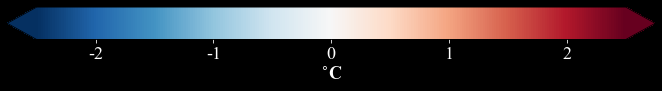

In [89]:
# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(10, 3), facecolor=bgcolor)
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.RdBu_r
normanom = mpl.colors.Normalize(vmin=-2.5, vmax=2.5)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=normanom,
                                orientation='horizontal', extend="both", format='%d')

cb1.set_label("$^{\circ}$C", fontsize=18, color=fgcolor, fontweight="bold")

cb1.ax.tick_params(axis='x', colors=fgcolor)
#cb1.ax.set_xticklabels(np.arange(-2., 2.1), color=fgcolor,  
#                       fontsize=16)

plt.savefig(os.path.join(figdir, "sst_colorbar.png"), dpi=300, bbox_inches="tight",
            facecolor=fig.get_facecolor())
plt.show()

## Time series
### Linear plot

In [ ]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(25, 7), facecolor=bgcolor)
plt.plot(SSTmeantime, SSTmeananom, "o-", color="#FFA731")
plt.xticks([datetime.date(yyyy, 1, 1) for yyyy in range(2000, 2021)])
plt.ylabel("SST\nanomaly\n($^{\circ}$C)", rotation=0, ha="right", fontsize=20)
plt.savefig(os.path.join(figdir, "MedSea_mean_SST.png"), facecolor=fig.get_facecolor(),
                dpi=300, bbox_inches="tight")
plt.show()

### Polar plot

/home/ctroupin/Software/PythonEnvs/Filament3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ctroupin/Software/PythonEnvs/Filament3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


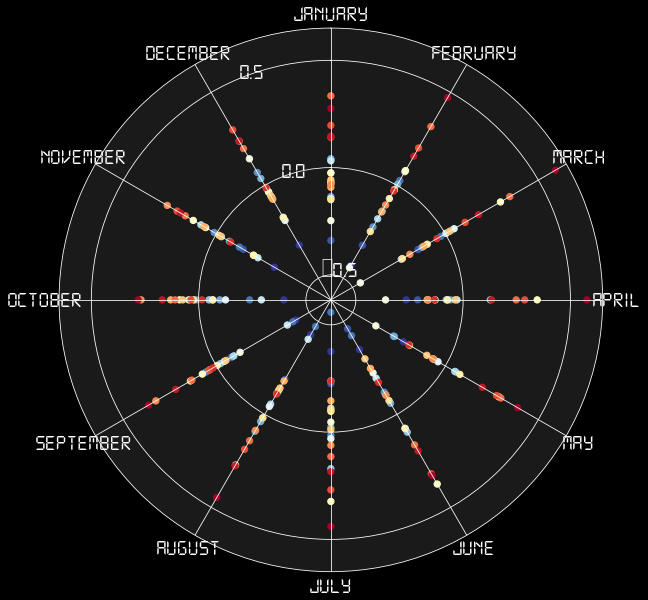

In [59]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
ax.set_facecolor('.1')
ax.set_rticks([-0.5, 0., 0.5, 1, 1.5, 2])  # less radial ticks
ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 30), labels=[calendar.month_name[ii] for ii in range(1, 13)], 
                  fontsize=20, fontproperties=myfont)
plt.setp(ax.get_xticklabels(), fontproperties=myfont, fontsize=22)
plt.setp(ax.get_yticklabels(), fontproperties=myfont, fontsize=22)
ax.scatter(anglelist, SSTmeananom, c=yearlist, s=40, cmap=plt.cm.RdYlBu_r)

In [53]:
monthlist = np.array([s.month for s in SSTmeantime])
yearlist = np.array([s.year for s in SSTmeantime])

In [41]:
anglelist = (monthlist - 1.) * np.pi / 6.